In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
from torchvision.models import efficientnet_b3 as eff
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import torch.optim as optim


from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.tensorboard import SummaryWriter


In [2]:
writer = SummaryWriter()

In [3]:
eff_net = eff(pretrained=True)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


In [5]:
train_path = 'data4/'
test_path = 'data2/'
val_path = 'test2/'

In [6]:
class Permute():
    def __init__(self, new_dimensions):
        self.new_dimensions = new_dimensions

    def __call__(self,img):
        return torch.permute(img, self.new_dimensions) * 255

In [7]:
class CircleTranform():
    def __init__(self, pixel_filter):
        self.filter = pixel_filter

    def __call__(self, img):
        return img * self.filter

In [8]:
def label_to_ohe(label):
    # print(label)
    temp = [0,0]
    temp.insert(label,1)
    # print(temp)
    return temp
    
def lable_encode(tensor):
    return torch.tensor([label_to_ohe(label) for label in tensor], dtype=float).to(device)

In [9]:
class CircleFilter:
    def __init__(self, shape, coeff):
        self.coeff = coeff
        self.shape = shape
        self.cicle_center = shape[1]//2, shape[2]//2
        self.radius = shape[1] // 2
        self.pixel_filter = np.random.random((shape[1], shape[2]))
        self.pixel_filter = self.create_filter(self.pixel_filter)

    def centr_distance(self, dot):
        return ((self.cicle_center[0] - dot[0])**2 + (self.cicle_center[1]-dot[1])**2)**(0.5)

    def create_filter(self, pixel_filter):
        for y in range(pixel_filter.shape[0]):
            for x in range(pixel_filter.shape[1]):

                if self.centr_distance( (y,x)) > self.radius * self.coeff:
                    pixel_filter[x,y] = 0
                else:
                    pixel_filter[x,y] = 1

        return np.array([
                    pixel_filter,
                    pixel_filter,
                    pixel_filter
                ])

In [10]:
img_size = (3,300,300)
freeze_batch_size = 64
unfreeze_batch_size = 10


In [ ]:
eff_net

In [12]:
circle_filter = CircleFilter(img_size, 1.1)

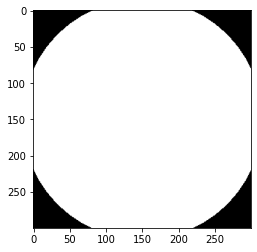

In [13]:
plt.imshow(torch.permute(torch.tensor(circle_filter.pixel_filter), (1,2,0)))

In [14]:
class WoodImageDataset(Dataset):
    def  __init__(self, img_folder, transform=None):

        self.img_folder = img_folder
        self.transform=transform
        self.all_files = os.listdir(img_folder)

    def __len__(self):
        return len(self.all_files)

    def __getitem__(self,idx):

        img = Image.open(self.img_folder + str(idx + 1) +'.png')
        label = idx + 1

        if self.transform:
            img = self.transform(img)

        return img , label

In [1]:
class DatasetWorngLabling(Dataset):
    def __init__(self, folder_path, transform=None):
        self.transform = transform
        self.folder_path = folder_path
        self.file_paths, self.file_labels = self.get_file_list(self.folder_path)
        

    def get_file_list(self, img_folder_path):
        class_names = os.listdir(img_folder_path)
        file_paths = []
        file_labels = []
        for class_name in class_names:
            for file_name in os.listdir(img_folder_path + class_name):
                file_paths.append(img_folder_path + class_name + '/' + file_name)
                file_labels.append(class_name)
        return file_paths, file_labels

    def __len__(self):
        return len(self.file_labels)
    
    def __getitem__(self, idx):
        img = Image.open(self.file_paths[idx])
        label = self.file_labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


NameError: name 'Dataset' is not defined

In [ ]:
# transform = transforms.Compose([transforms.Resize((256,256)),
#                                 transforms.ToTensor(),
#                                 Permute((1,2,0))])
train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.Resize(img_size[1:]),
    transforms.ToTensor(),
    # CircleTranform(circle_filter.pixel_filter.astype('float32')),
    transforms.ColorJitter(0.15,0.15)
    ]
)

test_transform = transforms.Compose([
    # transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.Resize(img_size[1:]),
    transforms.ToTensor(),
    # CircleTranform(circle_filter.pixel_filter.astype('float32')),
    transforms.ColorJitter(0.1,0.1)
    ]
)

val_transform = transforms.Compose([
    transforms.Resize(img_size[1:]),
    transforms.ToTensor(),
    # CircleTranform(circle_filter.pixel_filter.astype('float32'))
    ]
)

In [ ]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)
val_dataset = WoodImageDataset(val_path, transform=val_transform)
check_mistakes_dataset = DatasetWorngLabling(train_path,transform=val_transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=freeze_batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=freeze_batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
check_mistakes_loader = torch.utils.data.DataLoader(check_mistakes_dataset, batch_size=freeze_batch_size)
unfreeze_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=unfreeze_batch_size, shuffle=True, drop_last=True)

In [ ]:
for i in train_loader:
    img, labels = i
    break

tensor(0)


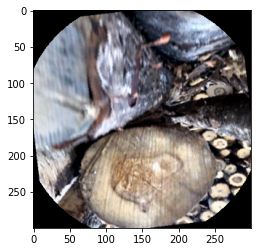

In [ ]:
print(labels[0])
plt.imshow((img[0] * circle_filter.pixel_filter).permute(1,2,0))

In [ ]:
img.shape

torch.Size([64, 3, 300, 300])

In [ ]:
for i in val_loader:
    img, labels = i
    break

In [ ]:
img[0].shape

torch.Size([3, 300, 300])

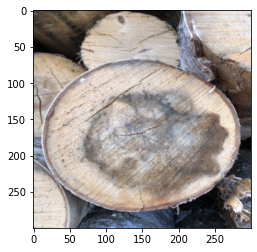

In [ ]:
plt.imshow(img[0].permute(1,2,0))

In [ ]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

Using cache found in C:\Users\zald/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\zald/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\zald/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [ ]:

# class Net(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.eff = torch.nn.Sequential(
#             efficientnet.stem,
#             efficientnet.layers,
#             efficientnet.features
#         )
#         self.classifier = torch.nn.Sequential(
#             torch.nn.AdaptiveAvgPool2d(output_size=1),
#             torch.nn.Flatten(),
#             torch.nn.Dropout(p=0.2, inplace=False),
#             # torch.nn.Linear(in_features=1280, out_features=1280, bias=True),
#             # torch.nn.BatchNorm1d(1280),
#             # torch.nn.ReLU(),
#             torch.nn.Linear(in_features=1280, out_features=3, bias=True),
#             torch.nn.Softmax(dim=1)
#         )



#         # self.stem = efficientnet.stem
#         # self.layers = efficientnet.layers
#         # self.features = efficientnet.features
#         # self.pooling = torch.nn.AdaptiveAvgPool2d(output_size=1)
#         # self.flatten = torch.nn.Flatten()
#         # self.drop = torch.nn.Dropout(p=0.2, inplace=False)
#         # self.linear = torch.nn.Linear(in_features=1280, out_features=3, bias=True)
#         # self.softmax = torch.nn.Softmax(dim=-1)

#     def forward(self, x):
#         # x = self.stem(x)
#         # x = self.layers(x)
#         # x = self.features(x)
#         # x = self.pooling(x) 
#         # x = self.flatten(x)
#         # x = self.drop(x)
#         # x = self.linear(x)
#         # x = torch.nn.functional.log_softmax(x, -1)
#         x = self.eff(x)
#         x = self.classifier(x)
#         return x


# net = Net().to(device)

In [ ]:

class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.eff = torch.nn.Sequential(
            eff_net.features,
            eff_net.avgpool,
            torch.nn.Flatten()
        )
        self.classifier = torch.nn.Sequential(
            # torch.nn.Flatten(),
            torch.nn.Dropout(p=0.2, inplace=False),
            # torch.nn.Linear(in_features=1280, out_features=1280, bias=True),
            # torch.nn.BatchNorm1d(1280),
            # torch.nn.ReLU(),
            torch.nn.Linear(in_features=1536, out_features=3, bias=True),
            torch.nn.Softmax(dim=1)
        )



        # self.stem = efficientnet.stem
        # self.layers = efficientnet.layers
        # self.features = efficientnet.features
        # self.pooling = torch.nn.AdaptiveAvgPool2d(output_size=1)
        # self.flatten = torch.nn.Flatten()
        # self.drop = torch.nn.Dropout(p=0.2, inplace=False)
        # self.linear = torch.nn.Linear(in_features=1280, out_features=3, bias=True)
        # self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        # x = self.stem(x)
        # x = self.layers(x)
        # x = self.features(x)
        # x = self.pooling(x) 
        # x = self.flatten(x)
        # x = self.drop(x)
        # x = self.linear(x)
        # x = torch.nn.functional.log_softmax(x, -1)
        x = self.eff(x)
        x = self.classifier(x)
        return x


net = Net().to(device)

In [ ]:
for param in net.eff.parameters():
    param.requires_grad = False

In [ ]:
# for epoch in range(10):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in tqdm(enumerate(trainloader, 0)):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs = inputs.to(device)
#         # zero the parameter gradients
#         optimizer.zero_grad()
#         # print(labels)
#         # forward + backward + optimize

#         outputs = net(inputs)
#         # print(outputs)
#         loss = criterion(outputs, lable_encode(labels))
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 2 == 0 and i != 0:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.8f}')
#             running_loss = 0.0

# print('Finished Training')

In [ ]:
def train(model, dataloader, num_epoch, freeze_backbone=True):
    epoch_loss = []
    if freeze_backbone:
        for param in model.eff.parameters():
            param.requires_grad = False
    else:
        for param in model.eff.parameters():
            param.requires_grad = True
        
    for batch in dataloader:
        inputs, labels = batch
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(inputs) # already softmaxed

        loss = criterion(outputs, lable_encode(labels))
        epoch_loss.append(loss.tolist())
        loss.backward()
        optimizer.step()

    writer.add_scalar('loss/train', np.mean(epoch_loss), num_epoch)
    num_epoch += 1
    return num_epoch


In [ ]:
# efficientnet

In [ ]:
def val(model, dataloader, num_epoch ,name):

    with torch.no_grad():

        preds = []
        true_labels = []

        for data in dataloader:
            img, labels = data
            batch_preds = model(img.to(device))
            preds.append(batch_preds)
            true_labels.append(labels)

        result = []

        for batch_preds in preds:
            result.extend([torch.argmax(i).tolist() for i in batch_preds])
        true_labels_resul = []

        for true_labels_batch in true_labels:
            true_labels_resul.extend(true_labels_batch.tolist())

        accuracy = accuracy_score(true_labels_resul,result)
        print(f'{name} accuracy =' , accuracy)

        writer.add_scalar('accuracy/test', accuracy, num_epoch)
        
        print(confusion_matrix(true_labels_resul,result))


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
lr = 0.01
optimizer = optim.AdamW(net.parameters(),lr=lr)
num_epoch = 0.0

In [ ]:
for epoch in range(100):  # loop over the dataset multiple times
    print(f'epoch #{epoch}')
    num_epoch = train(net, train_loader, num_epoch, freeze_backbone=True)
    if epoch % 5 == 0:
        val(net, test_loader, num_epoch, 'test')
    # val(net, train_loader, 'train' )
    # if epoch % 5 == 0 and epoch != 0:
    #     lr /= 2
    #     print(lr)
    #     optimizer = optim.Adam(net.parameters(), lr=lr)

epoch #0
test accuracy = 0.7569444444444444
[[ 75   1   0]
 [ 36 258   0]
 [ 74  29 103]]
epoch #1
epoch #2
epoch #3
epoch #4
epoch #5
test accuracy = 0.8940972222222222
[[ 79   0   0]
 [ 37 253   1]
 [ 15   8 183]]
epoch #6
epoch #7
epoch #8
epoch #9
epoch #10
test accuracy = 0.9392361111111112
[[ 76   1   1]
 [ 11 278   3]
 [ 10   9 187]]
epoch #11
epoch #12
epoch #13
epoch #14
epoch #15
test accuracy = 0.9375
[[ 76   0   0]
 [ 25 266   4]
 [  6   1 198]]
epoch #16
epoch #17
epoch #18
epoch #19
epoch #20
test accuracy = 0.9270833333333334
[[ 75   0   0]
 [ 23 264   8]
 [  8   3 195]]
epoch #21
epoch #22
epoch #23
epoch #24
epoch #25
test accuracy = 0.9131944444444444
[[ 75   0   2]
 [ 27 258   7]
 [ 13   1 193]]
epoch #26
epoch #27
epoch #28
epoch #29
epoch #30
test accuracy = 0.9236111111111112
[[ 77   0   0]
 [ 29 262   2]
 [ 13   0 193]]
epoch #31
epoch #32
epoch #33
epoch #34
epoch #35
test accuracy = 0.9131944444444444
[[ 78   0   0]
 [ 31 259   3]
 [ 16   0 189]]
epoch #36
epoc

In [ ]:
lr = 0.0001
optimizer = optim.Adam(net.parameters(), lr=lr)

In [ ]:
for epoch in range(150):  # loop over the dataset multiple times
    print(f'epoch #{epoch}')
    num_epoch = train(net, train_loader, num_epoch, freeze_backbone=True)
    if epoch % 5 == 0:
        val(net, test_loader,num_epoch, 'test')
    # val(net, train_loader, 'train' )
    # if epoch % 5 == 0 and epoch != 0:
    #     lr /= 2
    #     print(lr)
    #     optimizer = optim.Adam(net.parameters(), lr=lr)

In [ ]:
# for epoch in range(10):  # loop over the dataset multiple times
#     print(f'epoch #{epoch}')
#     running_loss = 0.0

#     optimizer = optim.Adam(net.parameters(), lr=0.00001)
#     for i in range(3):
#         train(net, train_loader, running_loss, freeze_backbone=False)

#     optimizer = optim.Adam(net.parameters(), lr=0.0001)
#     train(net, train_loader, running_loss, freeze_backbone=True)
    
#     if epoch % 1 == 0:
#         val(net, test_loader, 'test')
#     # val(net, train_loader, 'train' )
# val(net, test_loader, 'test')

In [ ]:
# optimizer = optim.Adam(net.parameters(), lr=0.00001)

In [ ]:
# for epoch in range(20):  # loop over the dataset multiple times
#     print(f'epoch #{epoch}')
#     running_loss = 0.0
#     train(net, train_loader, running_loss, freeze_backbone=False)
#     if epoch % 5 == 0:
#         val(net, test_loader, 'test')
#     # val(net, train_loader, 'train' )
# val(net, test_loader, 'test')

In [ ]:
optimizer = optim.AdamW(net.parameters(), lr=0.000001)

In [ ]:
optimizer = optim.RMSprop(net.parameters(), lr=0.000001)

In [ ]:
for epoch in range(50):  # loop over the dataset multiple times
    print(f'epoch #{epoch}')
    num_epoch = train(net, unfreeze_train_loader, num_epoch, freeze_backbone=False)
    if epoch % 2 == 0:
        val(net, test_loader,num_epoch, 'test')
    # val(net, train_loader, 'train' )


epoch #0
test accuracy = 0.9479166666666666
[[ 75   1   0]
 [ 20 274   2]
 [  6   1 197]]
epoch #1
epoch #2
test accuracy = 0.9409722222222222
[[ 77   0   0]
 [ 18 270   3]
 [  8   5 195]]
epoch #3
epoch #4
test accuracy = 0.9565972222222222
[[ 77   0   0]
 [ 16 273   3]
 [  3   3 201]]
epoch #5
epoch #6
test accuracy = 0.9565972222222222
[[ 78   0   0]
 [ 17 273   1]
 [  4   3 200]]
epoch #7
epoch #8
test accuracy = 0.9409722222222222
[[ 77   0   0]
 [ 21 271   3]
 [  8   2 194]]
epoch #9
epoch #10
test accuracy = 0.9427083333333334
[[ 77   0   0]
 [ 24 270   1]
 [  7   1 196]]
epoch #11
epoch #12
test accuracy = 0.9635416666666666
[[ 79   0   0]
 [  9 278   5]
 [  6   1 198]]
epoch #13
epoch #14
test accuracy = 0.9496527777777778
[[ 78   0   0]
 [ 19 274   1]
 [  8   1 195]]
epoch #15
epoch #16
test accuracy = 0.9496527777777778
[[ 75   0   0]
 [ 14 277   3]
 [ 11   1 195]]
epoch #17
epoch #18
test accuracy = 0.9427083333333334
[[ 79   0   0]
 [ 25 265   1]
 [  6   1 199]]
epoch #19


4 рана

In [ ]:
val(net, test_loader, num_epoch, 'test')

test accuracy = 0.953125
[[ 76   0   0]
 [ 14 278   2]
 [  9   2 195]]


In [ ]:
def make_prediction(model, dataloader, save_path=''):
    
    with torch.no_grad():
        
        preds = []
        file_ids = []

        for data in dataloader:
            img, ids = data
            batch_preds = model(img.to(device))
            preds.append(batch_preds)
            file_ids.extend(ids.tolist())

        result = []

        for batch_preds in preds:
            result.extend([torch.argmax(i).tolist() for i in batch_preds])
        
        
            
    return file_ids, result

In [ ]:
def print_wrong_preds_images(model, dataloader):

    with torch.no_grad():

        for data in dataloader:
            imgs = data[0]

            labels = data[1].tolist()
            batch_preds = torch.argmax(model(imgs.to(device)), dim=1).tolist()

            for i in range(len(labels)):
                if labels[i] != batch_preds[i]:
                    print(f'true label = {labels[i]}, pred label = {batch_preds[i]}')
                    plt.imshow(torch.permute(imgs[i], (1,2,0)))
                    plt.show()



true label = 1, pred label = 0


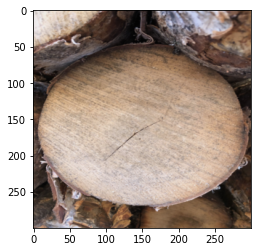

true label = 1, pred label = 0


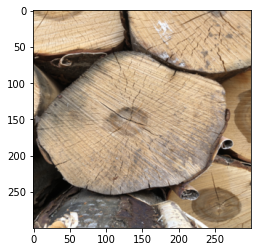

true label = 1, pred label = 0


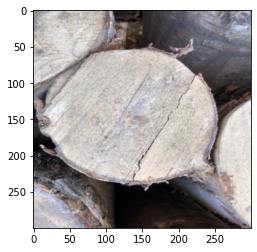

true label = 2, pred label = 0


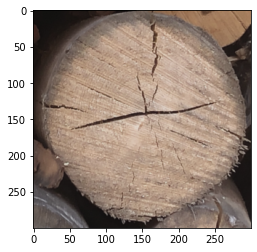

true label = 1, pred label = 0


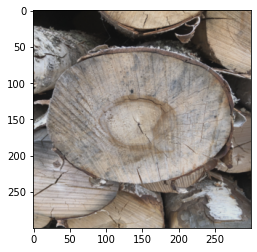

true label = 1, pred label = 0


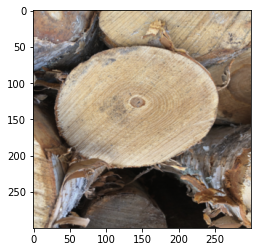

true label = 1, pred label = 0


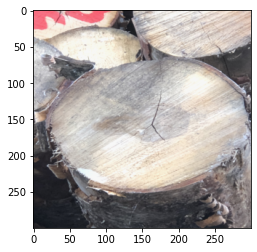

true label = 1, pred label = 0


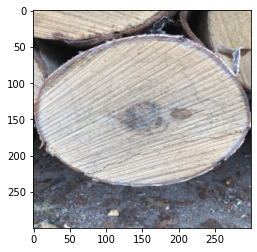

true label = 1, pred label = 0


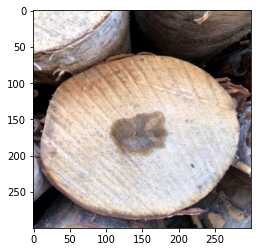

true label = 2, pred label = 0


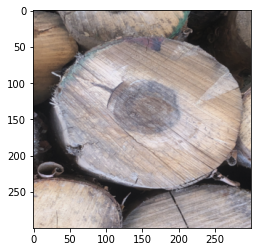

true label = 1, pred label = 0


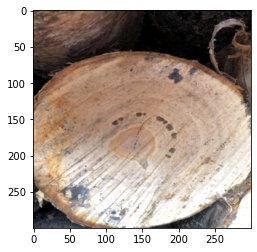

true label = 2, pred label = 0


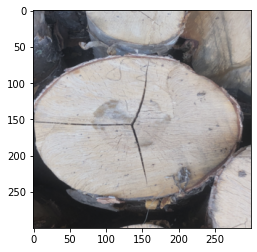

true label = 2, pred label = 0


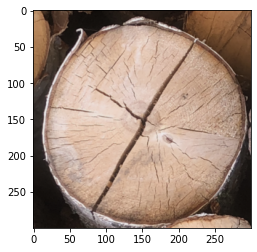

true label = 2, pred label = 0


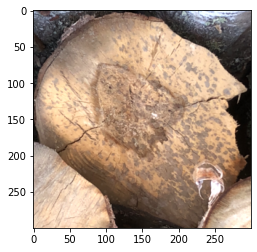

true label = 1, pred label = 0


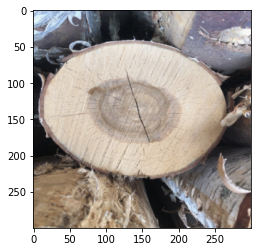

true label = 1, pred label = 0


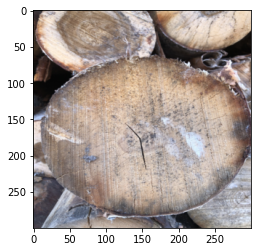

true label = 1, pred label = 0


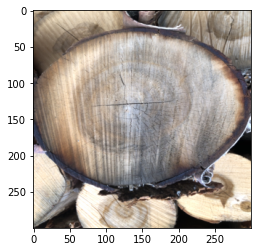

true label = 2, pred label = 0


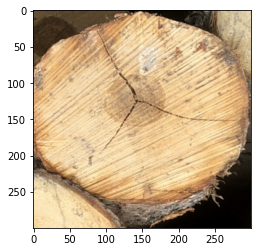

true label = 1, pred label = 0


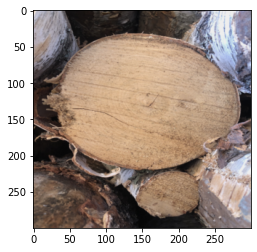

true label = 1, pred label = 0


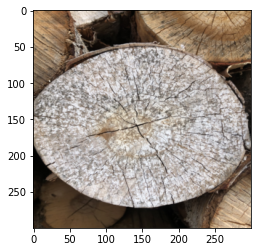

true label = 1, pred label = 0


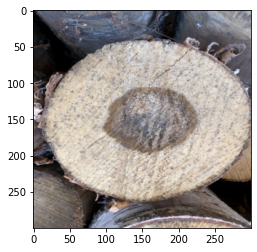

true label = 1, pred label = 0


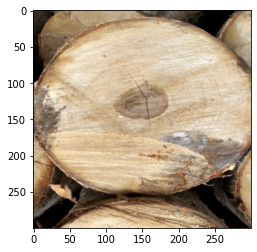

true label = 2, pred label = 0


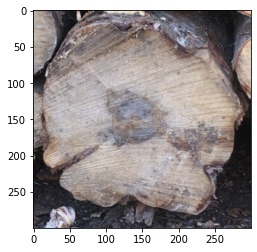

true label = 1, pred label = 0


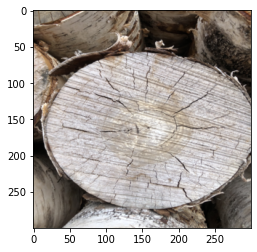

true label = 2, pred label = 0


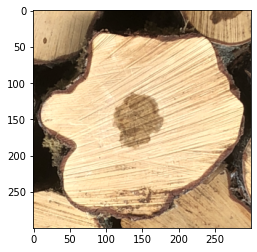

true label = 2, pred label = 0


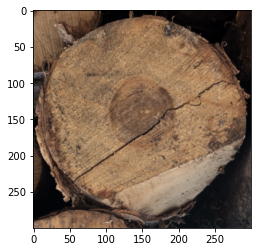

true label = 1, pred label = 0


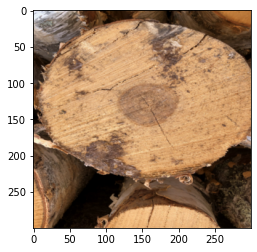

true label = 1, pred label = 0


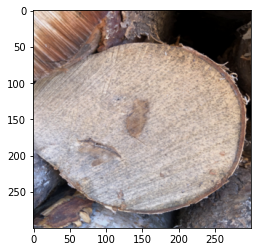

true label = 1, pred label = 0


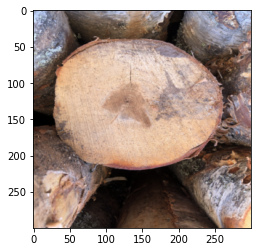

true label = 2, pred label = 0


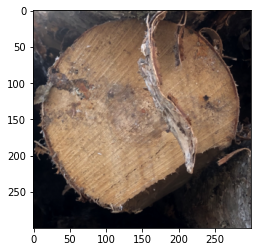

In [ ]:
print_wrong_preds_images(net, test_loader)

In [ ]:
preds = make_prediction(net, val_loader)

In [ ]:
df = pd.DataFrame(np.array(preds)).T

In [ ]:
df.columns = ('id', 'class')

In [ ]:
df['class'] = df['class'].apply(lambda x: 3 if x==2 else x)

In [ ]:
df.to_csv('hello.csv',index=0)